![](https://i.ibb.co/7pC1Y9q/lungs.jpg)

<p style='text-align: right;'><span style="color: #000508; font-family: Segoe UI; font-size: 0.7em; font-weight: 300;">Image Source: www.nhlbi.nih.gov</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">SIIM COVID-19 Resize & Process + Coco Dataset</span></p>

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Overview</span>

<p style='text-align: justify;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">This notebook covers the following:</span></p>

- Read Dicom Images
- Resize and Save to PNG
- Generate Metadata for Train and Test Datasets
- Process and Resize Bounding Boxes
- Visualise Images
- GroupKFold Train-Val Split
- Generate GroupKFold COCO Dataset

<br>

<p style='text-align: justify;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 400;">Version Notes:</span></p>

- V5: Added segmentations=[] to coco annotations. Removed images without bboxes in coco annotations
- V3: Generated resized images, annotations and COCO GroupKFold dataset for sizes 256x256, 512x512 & 768x768
- V2: Initial version, generated 512x512 resized images, annotations and COCO GroupKFold dataset for images with bboxes


<br>

<p style='text-align: justify;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">The resized images and the COCO Annotations in this notebook are registered as datasets:</span></p>

**SIIM Covid19 Images & Metadata 256 512 768**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-images-metadata-256-512-768

**SIIM Covid-19 COCO 256 512 768 GroupKFold**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-coco-256-512-768-groupkfold

**SIIM covid19 512 images and metadata**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-512-images-and-metadata

**SIIM Covid-19 COCO 512x512 GroupKFold**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-coco-512x512-groupkfold

I will update these datasets if needed, when the issues in the discussions regarding the dataset are resolved by the organizers.


### References

- https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
- https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
- https://www.kaggle.com/sreevishnudamodaran/vinbigdata-fusing-bboxes-coco-dataset

<br>

<a href="https://www.kaggle.com/sreevishnudamodaran"><center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Ask%20me-something-1abc9c.svg?style=flat-square&logo=kaggle" width="130" height="10"></center></a>

<center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Please-Upvote%20If%20you%20like%20this-07b3c8?style=for-the-badge&logo=kaggle" width="260" height="20"></center>

In [1]:
!conda install gdcm -c conda-forge -y

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_0         3.1 MB  conda-forge
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
   

In [2]:
import os
import ast
import numpy as np
import pandas as pd
from path import Path
import datetime
import glob
import json
import shutil

from PIL import Image
from tqdm.auto import tqdm
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Read Dicom Images and  Resize and Save to PNG</span>

In [3]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)    
    
    return data

In [4]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail(size, resample)
    else:
        im = im.resize(size, resample)
    
    return im

In [5]:
images_meta_folder = '/kaggle/working/images_metadata_256_512_768'
os.makedirs(images_meta_folder, exist_ok=True)

# Define sizes
new_sizes = [(256, 256), (512, 512), (768, 768)]

In [6]:
for new_size in new_sizes:

    for split in ['train', 'test']:
    # for split in ['test']:
        save_dir = f'/kaggle/tmp/{split}_{new_size[0]}x{new_size[1]}/'
        dcm_paths = glob.glob(f'../input/siim-covid19-detection/{split}/*/*/*')
        os.makedirs(save_dir, exist_ok=True)

        image_ids = []
        folder_ids = []
        study_ids = []
        widths = []
        heights = []

        for path in tqdm(dcm_paths):
            # set keep_ratio=True to have original aspect ratio
            xray = read_xray(path)
            im = resize(xray, size=new_size)

            path_split = path.split('/')
            study_id = path_split[-3]
            folder_id = path_split[-2]
            image_name = path_split[-1].replace('.dcm', '_image')

            im.save(os.path.join(save_dir, image_name+'.png'))

            image_ids.append(image_name)
            folder_ids.append(folder_id)
            study_ids.append(study_id)
            widths.append(xray.shape[1])
            heights.append(xray.shape[0])
            
        df = pd.DataFrame.from_dict({'id': image_ids, 'folder_id': folder_ids,
                                     'study_id': study_ids, 'width': widths,
                                     'height': heights})
        df.to_csv(f'{images_meta_folder}/{split}_meta_{new_size[0]}x{new_size[1]}.csv', index=False)

  0%|          | 0/6334 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


  0%|          | 0/1263 [00:00<?, ?it/s]

  0%|          | 0/6334 [00:00<?, ?it/s]

  0%|          | 0/1263 [00:00<?, ?it/s]

  0%|          | 0/6334 [00:00<?, ?it/s]

  0%|          | 0/1263 [00:00<?, ?it/s]

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Process and Resize Bounding Boxes</span>

In [7]:
for new_size in new_sizes:
    print(f"*****{new_size}*****\n")
    df_train_meta = pd.read_csv(f'{images_meta_folder}/train_meta_{new_size[0]}x{new_size[1]}.csv')
    df_train = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
    df_train_meta = df_train.merge(df_train_meta, on='id')
    
    ## Drop all rows of images without annotations
    df_train_meta = df_train_meta.dropna()
    imagepaths = df_train_meta.id.unique()
    print("Number of Images with Covid_Abnormality:",len(imagepaths))
    
    display(df_train_meta.head(3))
    print()
    
    df_idx=0

    for idx, row in tqdm(df_train_meta.iterrows(), total=df_train_meta.shape[0]):
        img = cv2.imread(os.path.join(f"/kaggle/tmp/train_{new_size[0]}x{new_size[1]}/",
                                      row.id.replace("_image", ".png")))
        bboxes = [list(bbox.values()) for bbox in ast.literal_eval(row.boxes)]
        height_ratio, width_ratio = (new_size[0]/row.height, new_size[1]/row.width)

        for box in bboxes:
            box[2] = box[2]+box[0]
            box[3] = box[3]+box[1]
            box = (box[0]*width_ratio, box[1]*height_ratio,
                   box[2]*width_ratio, box[3]*height_ratio)

            row_df = pd.DataFrame({'id':row.id,
                           'StudyInstanceUID':row.StudyInstanceUID,
                           'folder_id':row.folder_id,
                           'study_id':row.study_id,
                           'width':row.width,
                           'height':row.height,
                           'xmin':round(box[0]),
                           'ymin':round(box[1]),
                           'xmax':round(box[2]),
                           'ymax':round(box[3])}, index=[df_idx])

            if df_idx==0:
                df_train_processed = row_df
            else:
                df_train_processed = pd.concat([df_train_processed, row_df])

            df_idx+=1

    display(df_train_processed.head(3))
    print()
    df_train_processed.to_csv(f'{images_meta_folder}/df_train_processed_meta_{new_size[0]}x{new_size[1]}.csv',
                              index=False)
    df_train_processed.shape

*****(256, 256)*****

Number of Images with Covid_Abnormality: 4294


,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,4d47bc042ee6,28dddc8559b2,4280,3520


  0%|          | 0/4294 [00:00<?, ?it/s]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax
0,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,47,43,109,183
1,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,135,43,201,173
2,0012ff7358bc_image,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544,57,20,129,121



*****(512, 512)*****

Number of Images with Covid_Abnormality: 4294


,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,4d47bc042ee6,28dddc8559b2,4280,3520


  0%|          | 0/4294 [00:00<?, ?it/s]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax
0,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,95,85,218,367
1,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,270,87,402,345
2,0012ff7358bc_image,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544,113,40,259,241



*****(768, 768)*****

Number of Images with Covid_Abnormality: 4294


,id,boxes,label,StudyInstanceUID,folder_id,study_id,width,height
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,4d47bc042ee6,28dddc8559b2,4280,3520


  0%|          | 0/4294 [00:00<?, ?it/s]

,id,StudyInstanceUID,folder_id,study_id,width,height,xmin,ymin,xmax,ymax
0,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,142,128,328,550
1,000a312787f2_image,5776db0cec75,81456c9c5423,5776db0cec75,4256,3488,405,130,603,518
2,0012ff7358bc_image,9d514ce429a7,22897cd1daa0,9d514ce429a7,3056,2544,170,60,388,362


<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Visualise Images</span>

In [8]:
def draw_bbox(image, box, label, color, scale=1.0):   
    alpha = 0.1
    alpha_box = 0.6
    font_size = round(0.6*scale, 1)
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, font_size, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), 1, cv2.LINE_AA)
    return output

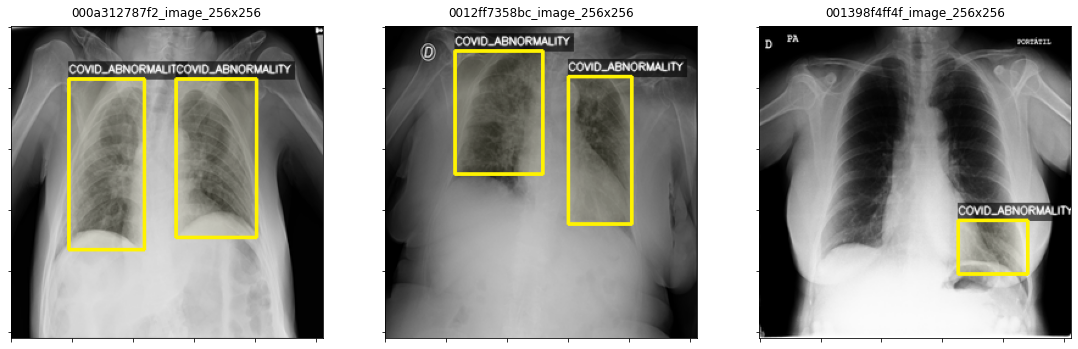

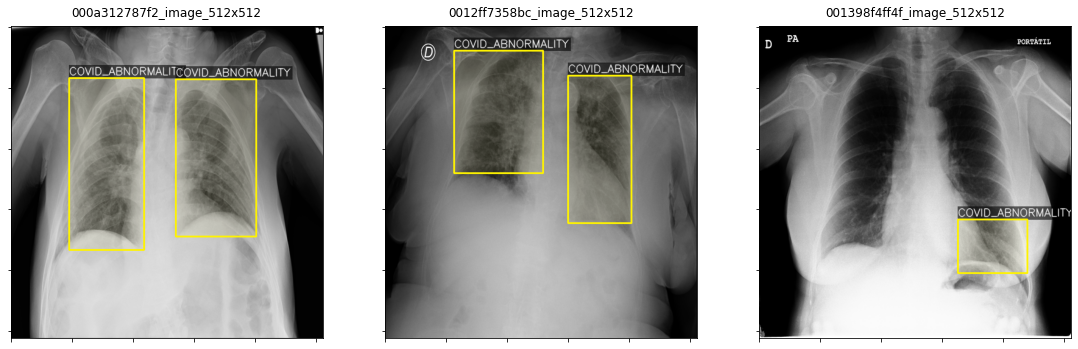

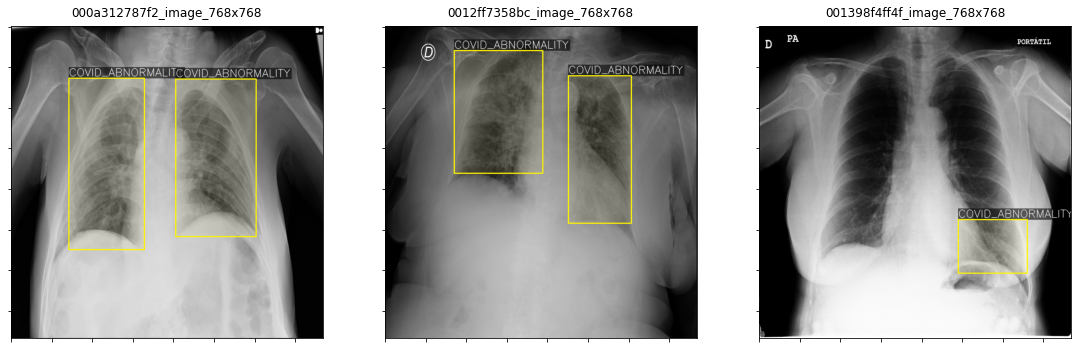

In [9]:
for new_size in new_sizes:
    imgs_path = f"/kaggle/tmp/train_{new_size[0]}x{new_size[1]}/"
    df_train_processed = pd.read_csv(f"{images_meta_folder}/df_train_processed_meta_{new_size[0]}x{new_size[1]}.csv")
    
    fig, axes = plt.subplots(1,3, figsize=(19,7))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = axes.ravel()
    pos = 0

    for idx, img_id in enumerate(imagepaths[:3]):
        img = cv2.imread(os.path.join(imgs_path, img_id+".png"))
        img_annotations = df_train_processed[df_train_processed.id==img_id]
        bboxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy().tolist()

        for box in bboxes:
            img = draw_bbox(img, list(np.int_(box)), "Covid_Abnormality",
                            (255, 243, 0), scale=new_size[0]/512)

        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'{img_id}_{new_size[0]}x{new_size[1]}', size=12, pad=10)
        axes[idx].set_xticklabels([])
        axes[idx].set_yticklabels([])

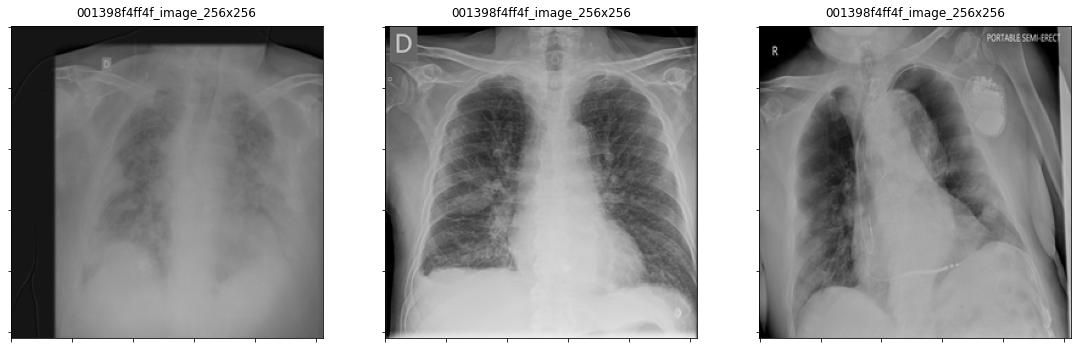

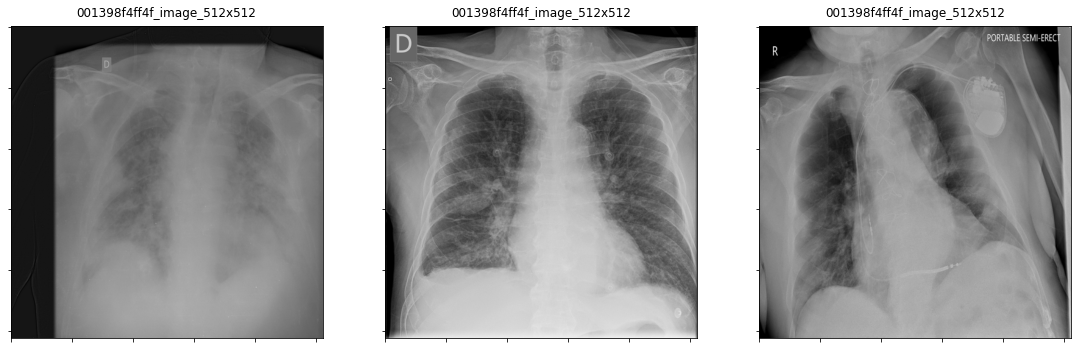

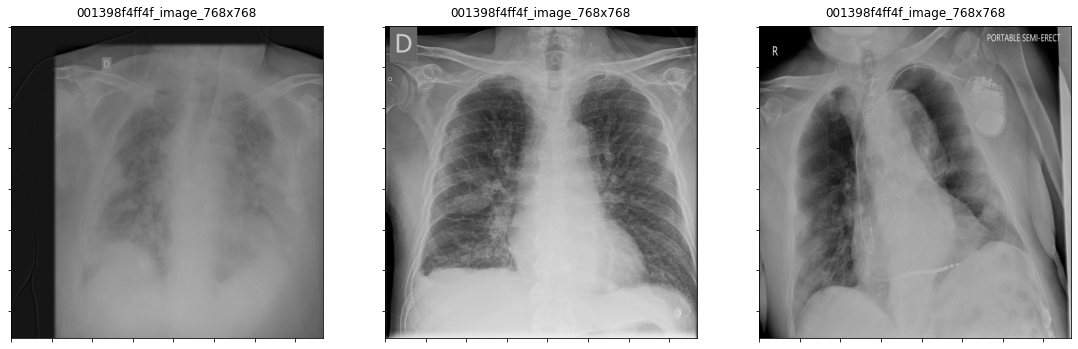

In [10]:
for new_size in new_sizes:
    df_test = pd.read_csv(f"{images_meta_folder}/test_meta_{new_size[0]}x{new_size[1]}.csv")

    fig, axes = plt.subplots(1, 3, figsize=(19,21))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = axes.ravel()
    pos = 0

    for idx in df_test.id[:3]:
        img = cv2.imread(os.path.join(f"/kaggle/tmp/test_{new_size[0]}x{new_size[1]}/", idx+'.png'))
        axes[pos].imshow(img, cmap='gray')
        axes[pos].set_title(f'{img_id}_{new_size[0]}x{new_size[1]}', size=12, pad=10)
        axes[pos].set_xticklabels([])
        axes[pos].set_yticklabels([])
        pos += 1

In [11]:
# !cp -r /kaggle/tmp/train* images_metadata_256_512_768/
# !cp -r /kaggle/tmp/test* images_metadata_256_512_768/
# !zip -rq images_metadata_256_512_768.zip images_metadata_256_512_768/*

In [12]:
# from kaggle_secrets import UserSecretsClient
# from google.cloud import storage

# def upload_blob(bucket_name, source_file_name, destination_blob_name):
#     """Uploads a file to the bucket. https://cloud.google.com/storage/docs/ """
#     bucket = storage_client.get_bucket(bucket_name)
#     blob = bucket.blob(destination_blob_name)
#     blob.upload_from_filename(source_file_name)
#     print('File {} uploaded to {}.'.format(
#         source_file_name,
#         destination_blob_name))

# user_secrets = UserSecretsClient()
# gcp_project_id = user_secrets.get_secret("gcp_project_id")
# storage_client = storage.Client(project=gcp_project_id)
# upload_blob('siim-files', 'images_metadata_256_512_768.zip', 'images_metadata_256_512_768_2.zip')

In [13]:
# !cd ./images_metadata_256_512_768 && rm -r train_256x256 train_512x512 train_768x768 test_256x256 test_512x512 test_768x768
# !rm ./images_metadata_256_512_768.zip

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Images and Metadata Datasets</span>


The resized images and the annotations generated above are in this dataset:

**SIIM Covid19 Images & Metadata 256 512 768**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-images-metadata-256-512-768


The resized images and the annotations generated in the previous version of this notebook are in this dataset:

**SIIM covid19 512 images and metadata**

https://www.kaggle.com/sreevishnudamodaran/siim-covid19-512-images-and-metadata

<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">GroupKFold Train-Val Split</span>

In [14]:
from sklearn.model_selection import GroupKFold, train_test_split

# Remove images without bboxes
df_kfold = pd.DataFrame(pd.read_csv("../input/siim-covid19-detection/train_image_level.csv"))
print("Shape before removing images without bboxes:", df_kfold.shape)
df_kfold = (df_kfold[df_kfold.label!='none 1 0 0 1 1']).reset_index(drop=True)
print("Shape after removing images without bboxes:", df_kfold.shape)

kfold = 5
df_kfold['fold'] = -1
group_kfold  = GroupKFold(n_splits = kfold)

for fold, (train_index, val_index) in enumerate(group_kfold.split(df_kfold,
                                                              groups=df_kfold.StudyInstanceUID.tolist())):
    df_kfold.loc[val_index, 'fold'] = fold
    
display(df_kfold.head(3))
df_kfold.to_csv("/kaggle/working/df_meta_kfold.csv")

Shape before removing images without bboxes: (6334, 4)
Shape after removing images without bboxes: (4294, 4)


,id,boxes,label,StudyInstanceUID,fold
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,4
1,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
2,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,2


In [15]:
val_fold = 0
train_ids = df_kfold[df_kfold['fold'] != fold].id.unique()
val_ids = df_kfold[df_kfold['fold'] == fold].id.unique()

print("Split Counts\nTrain Images:\t\t{0}\nVal Images:\t\t{1}"
      .format(len(train_ids), len(val_ids)))

Split Counts
Train Images:		3436
Val Images:		858


<span style="color: #0087e4; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Generate GroupKFold COCO Dataset</span>

### COCO Format Overview


```python
{
  "type": "instances",
  "images": [
    {
      "file_name": "<image_name.png>",
      "height": "<height>",
      "width": "<width>",
      "id": "<Used to reference each image and it should be unique for each image>"
    }
#    .
#    .
  ],
  "categories": [
    {
      "supercategory": "none",
      "name": "<Class One>",
      "id": 0
    },
#    .
#    .
  ],
  "annotations": [
    {
      "id": 1,
      "bbox": [
        "<xmin>",
        "<ymin>",
        "<bbox-width>",
        "<bbox-height>"
      ],
      "image_id": "<id of the image from which the polygon annotation is from as defined in the 'images' block above>",
      "segmentation": [
          "<x1>",
          "<y1>",
          "<x2>",
          "<y2>"
#          .
#          .
      ],
      "ignore": 0,
      "area": "<Area of the Polygon represented by the points in the 'segmentation' block>",
      "iscrowd": 0,
      "category_id": "<Class category ID as an integer which will be defined below>"
    },
  ],
"categories": [
    {
        "supercategory": null,
        "id": "<Integer ID for the Class Label>",
        "name": "<Class One Label as a String>"
    },
#    .
#    .
]
}
```

In [16]:
now = datetime.datetime.now()

data = dict(
    info=dict(
        description='SIIM Covid-19 GroupKfold',
        url=None,
        version=None,
        year=now.year,
        contributor=None,
        date_created=now.strftime('%Y-%m-%d %H:%M:%S.%f'),
    ),
    licenses=[dict(
        url=None,
        id=0,
        name=None,
    )],
    images=[
        # license, url, file_name, height, width, date_captured, id
    ],
    type='instances',
    annotations=[
        # segmentation, area, iscrowd, image_id, bbox, category_id, id
    ],
    categories=[
        # supercategory, id, name
    ],
)

In [17]:
class_name_to_id = {}
labels =  ["__ignore__",
            "Covid_Abnormality"]

for i, each_label in enumerate(labels):
    class_id = i - 1  # starts with -1
    class_name = each_label
    if class_id == -1:
        assert class_name == '__ignore__'
        continue
    class_name_to_id[class_name] = class_id
    data['categories'].append(dict(
        supercategory=None,
        id=class_id,
        name=class_name,
    ))
data

{'info': {'description': 'SIIM Covid-19 GroupKfold',
  'url': None,
  'version': None,
  'year': 2021,
  'contributor': None,
  'date_created': '2021-07-25 13:30:16.210827'},
 'licenses': [{'url': None, 'id': 0, 'name': None}],
 'images': [],
 'type': 'instances',
 'annotations': [],
 'categories': [{'supercategory': None, 'id': 0, 'name': 'Covid_Abnormality'}]}

In [18]:
images_meta_folder = '/kaggle/input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768'

for new_size in new_sizes:
    for fold in range(kfold):
        train_ids = df_kfold[df_kfold['fold'] != fold].id.unique()
        val_ids = df_kfold[df_kfold['fold'] == fold].id.unique()
        print(f"\nFold: {fold}\n Train images count: {len(train_ids)}, Val images count: {len(val_ids)}")
        
        coco_dir = f'coco_{new_size[0]}x{new_size[1]}'
        os.makedirs(coco_dir, exist_ok=True)

        df_annotations = pd.read_csv(f"{images_meta_folder}/df_train_processed_meta_{new_size[0]}x{new_size[1]}.csv")

        ## Setting the output annotation json file paths
        train_out_file = f'{coco_dir}/train_annotations_fold{fold}_{new_size[0]}x{new_size[1]}.json'
        val_out_file = f'{coco_dir}/val_annotations_fold{fold}_{new_size[0]}x{new_size[1]}.json'

        data_train = data.copy()
        data_train['images'] = []
        data_train['annotations'] = []
        data_val = data.copy()
        data_val['images'] = []
        data_val['annotations'] = []

        for i, img_id in tqdm(enumerate(train_ids), total=len(train_ids)):

            data_train['images'].append(dict(license=0,
                                             url=None,
                                             file_name=img_id+'.png',
                                             height=new_size[0],
                                             width=new_size[1],
                                             date_captured=None,
                                             id=i
                                            ))

            img_annotations = df_annotations[df_annotations.id==img_id]
            boxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
            box_labels = np.zeros(img_annotations.shape[0])

            for box, label in zip(boxes, box_labels):
                x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
                area = round((x_max-x_min)*(y_max-y_min),1)
                bbox =[
                        int(x_min),
                        int(y_min),
                        int(x_max-x_min),
                        int(y_max-y_min)
                        ]

                data_train['annotations'].append(dict(id=len(data_train['annotations']),
                                                      image_id=i,
                                                      category_id=int(label),
                                                      area=int(area),
                                                      bbox=bbox,
                                                      segmentation=[],
                                                      iscrowd=0)) 
        with open(train_out_file, 'w') as f:
            json.dump(data_train, f, indent=4)

        for i, img_id in tqdm(enumerate(val_ids), total=len(val_ids)):
            data_val['images'].append(dict(license=0,
                                             url=None,
                                             file_name=img_id+'.png',
                                             height=new_size[0],
                                             width=new_size[1],
                                             date_captured=None,
                                             id=i
                                            ))

            img_annotations = df_annotations[df_annotations.id==img_id]
            boxes = img_annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
            box_labels = np.zeros(img_annotations.shape[0])

            for box, label in zip(boxes, box_labels):
                x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
                area = round((x_max-x_min)*(y_max-y_min),1)
                bbox =[
                        int(x_min),
                        int(y_min),
                        int(x_max-x_min),
                        int(y_max-y_min)
                        ]

                data_val['annotations'].append(dict(id=len(data_val['annotations']),
                                                    image_id=i,
                                                    category_id=int(label),
                                                    area=int(area),
                                                    bbox=bbox,
                                                    segmentation=[],
                                                    iscrowd=0))             
        with open(val_out_file, 'w') as f:
            json.dump(data_val, f, indent=4)


Fold: 0
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 1
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 2
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 3
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 4
 Train images count: 3436, Val images count: 858


  0%|          | 0/3436 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]


Fold: 0
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 1
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 2
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 3
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 4
 Train images count: 3436, Val images count: 858


  0%|          | 0/3436 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]


Fold: 0
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 1
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 2
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 3
 Train images count: 3435, Val images count: 859


  0%|          | 0/3435 [00:00<?, ?it/s]

  0%|          | 0/859 [00:00<?, ?it/s]


Fold: 4
 Train images count: 3436, Val images count: 858


  0%|          | 0/3436 [00:00<?, ?it/s]

  0%|          | 0/858 [00:00<?, ?it/s]

In [19]:
!mkdir ./metadata_256_512_768
!cp ../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/*.csv ./metadata_256_512_768
!mv /kaggle/working/df_meta_kfold.csv ./metadata_256_512_768

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.4em; font-weight: 300;">Let me know if you have any suggestions!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.0em; font-weight: 300;">THANKS!</span></p>